# Introduction 

This is the programming code for my dissertation for my MSc data Science course at Nottingham Trent University.

I followed the CRISP-DM process to develop this data mining project. 

CRISP-DM is a non-proprietary and freely available data mining methodology that fits data mining into the general problem-solving strategy of business/research unit [He, 2021](https://www.kaggle.com/code/jhskaggle/l02-crisp-dm/notebook). it is a guide to help plan, organize, and implement data science (or machine learning) projects. CRISP-DM was concieved in 1996 by a collaboarative effort of DaimlerChrysler, SPSS, and NCR

CRISP-DM is an iterative, adaptive life cycle consisting of six phases. The 6 phases are:
* Business Understanding
* data Understanding
* data Preparation
* Modeling
* Evaluation
* Deployment

![image](../crisp_dm.png)|
|:--:| 
|the six phases of CRISP-DM

## Load needed libraries

In [105]:
#import important libraries
import pandas as pd
import numpy as np
from statistics import mode
import random
import re
import datetime as dt 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pickle
# from pathlib import Path

# preprocessing tool
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# modeling tool
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestClassifier

# novelty detection models
from sklearn.svm import OneClassSVM
from  sklearn.ensemble import IsolationForest
from  sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

font1 = {'family':'serif','color':'blue','size':30}
font2 = {'family':'serif','color':'darkred','size':20}
font3 = {'family':'serif','color':'red','size':10}

## Functions

In [32]:
def extract_tcp_flag(n):
  pattern = r"\d\[\w*\W*\w*]|\W\[\w*\W*\w*]"
  pattern2 = r"[A-Z]{3}"
  a =      ''.join(re.split("\s", n))
  b =    re.findall(pattern, a)
  return ''.join(re.findall(pattern2, b[0])) if b else 'NONE'

def difference_fist_last(x):
    return x.iloc[-1] - x.iloc[0]

def strip_seconds (time):
    'return the seconds and microseconds part of a timedelta object as a float (sec.microseconds)'
    return round(float(str(time).split()[2].split(':')[2]),5)

def get_tcp_flag(n):
  return ''.join(re.findall("[a-zA-Z]", n)) 

def time_filter (df, time_colname='Time', dur=60, start_time=None):
  "this filter a timeseries dataframe for specified period set by the dur"
  if start_time is None: start_time = df[time_colname][0]
  end = start_time + dt.timedelta(minutes=dur) 
  data = df.query(f"{time_colname} >= '{start_time}' & \
    {time_colname} <= '{end}'")  
  checker = data[time_colname].to_list()[-1]-data[time_colname].to_list()[0]
  # debuggers
  # print (checker.to_pytimedelta())
  assert  checker <= dt.timedelta(minutes=dur), 'error in result'
  return data 

def calc_time_diff (timer):
  "this calculate the differences between two consecutive values in a \
  list of timeDelta object"
  time_diff = [0.00]
  _ = [time_diff.append(round(float(str(b - a).split()[2].split(':')[2]),2)) 
        for a, b in zip(timer, timer[1:])]
  return time_diff
        
def is_keep_alive(n):
  pattern = r"TCP\sKeep-Alive"
  return True if re.findall(pattern, n) else False

## read the data

In [155]:
# Read in the data
filepath = 'Dataset/alldevices_extended.csv'
df = pd.read_csv(filepath, encoding='latin1', parse_dates = ['Time'])

# Filter for traffic to/from smart device to avoid other background traffics
hive_ipaddr = "192.168.0.101"
df.query(f'Source == "{hive_ipaddr}" | Destination == "{hive_ipaddr}"', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,No.,Time,Source,Destination,Protocol,Length,Time since previous frame in this TCP stream,Time delta from previous captured frame,Sequence Number,TCP Flags,This is an ACK to the segment in frame,TCP payload,Payload,Header Length,Info
0,5,2022-08-31 09:38:36.520313,192.168.0.101,52.210.184.200,TCP,66,0.000000,1.191316,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,NaN,NaN,NaN,32.0,58088 > 443 [ACK] Seq=1 Ack=1 Win=8022 Len=0...
1,6,2022-08-31 09:38:36.539808,52.210.184.200,192.168.0.101,TCP,66,0.019495,0.019495,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,NaN,NaN,NaN,32.0,[TCP ACKed unseen segment] 443 > 58088 [ACK]...
2,7,2022-08-31 09:38:37.020608,192.168.0.101,34.240.107.124,TLSv1.2,97,0.000000,0.480800,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,NaN,170303001a00000000000005b6f2a077839265cf66d18b...,NaN,32.0,Application Data
3,8,2022-08-31 09:38:37.042073,34.240.107.124,192.168.0.101,TLSv1.2,97,0.021465,0.021465,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,7.0,170303001a00000000000005b7261c56c3a2b256f85e57...,NaN,32.0,Application Data
4,9,2022-08-31 09:38:37.042570,192.168.0.101,34.240.107.124,TCP,66,0.000497,0.000497,32.0,\302\267\302\267\302\267\302\267\302\267\302\2...,8.0,NaN,NaN,32.0,49730 > 443 [ACK] Seq=32 Ack=32 Win=1002 Len...


# Exploratory Data Analysis (EDA)

## undestand the data

In [34]:
# the shape of the data - to checkk how many rows and columns are in the date
print (f'The data contains {df.shape[0]} rows and {df.shape[1]} columns')

# total duration of flow
print('Total duration of data capture is :')
total_duration = difference_fist_last(df.Time)
print(total_duration.to_pytimedelta())

# fist 5 rows of the data
print('The first 5 rows are as displayed below')
df.head()

The data contains 7953 rows and 15 columns
Total duration of data capture is :
2:54:14.826671
The first 5 rows are as displayed below


,No.,Time,Source,Destination,Protocol,Length,Time since previous frame in this TCP stream,Time delta from previous captured frame,Sequence Number,TCP Flags,This is an ACK to the segment in frame,TCP payload,Payload,Header Length,Info
0,5,2022-08-31 09:38:36.520313,192.168.0.101,52.210.184.200,TCP,66,0.000000,1.191316,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,NaN,NaN,NaN,32.0,58088 > 443 [ACK] Seq=1 Ack=1 Win=8022 Len=0...
1,6,2022-08-31 09:38:36.539808,52.210.184.200,192.168.0.101,TCP,66,0.019495,0.019495,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,NaN,NaN,NaN,32.0,[TCP ACKed unseen segment] 443 > 58088 [ACK]...
2,7,2022-08-31 09:38:37.020608,192.168.0.101,34.240.107.124,TLSv1.2,97,0.000000,0.480800,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,NaN,170303001a00000000000005b6f2a077839265cf66d18b...,NaN,32.0,Application Data
3,8,2022-08-31 09:38:37.042073,34.240.107.124,192.168.0.101,TLSv1.2,97,0.021465,0.021465,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,7.0,170303001a00000000000005b7261c56c3a2b256f85e57...,NaN,32.0,Application Data
4,9,2022-08-31 09:38:37.042570,192.168.0.101,34.240.107.124,TCP,66,0.000497,0.000497,32.0,\302\267\302\267\302\267\302\267\302\267\302\2...,8.0,NaN,NaN,32.0,49730 > 443 [ACK] Seq=32 Ack=32 Win=1002 Len...


In [35]:
print('the attributes in the data are:')
df.columns.to_list()

the attributes in the data are:


['No.',
 'Time',
 'Source',
 'Destination',
 'Protocol',
 'Length',
 'Time since previous frame in this TCP stream',
 'Time delta from previous captured frame',
 'Sequence Number',
 'TCP Flags',
 'This is an ACK to the segment in frame',
 'TCP payload',
 'Payload',
 'Header Length',
 'Info']

In [36]:
def feature_row_counter (column_name = 'Time', step = 5):
    row_counter = []
    # durs = []
    for dur in range(0,4*60,step):
        mins = dt.timedelta(minutes=dur) 
        start = df[column_name][0] + mins
        end = start + dt.timedelta(minutes=step)   
        if mins <= total_duration:
            # print(mins, start, end)
            r = df.query(f"{column_name} >= '{start}' & {column_name} < '{end}'")
            d = r[column_name].to_list()[-1]-r[column_name].to_list()[0]
            # durs.append(d)
            row_counter.append(r.shape[0])

    # for debugging
    assert r[column_name].values[-1] == df[column_name].values[-1],\
        'last row from last dataframe generated from the above loop\
            should be the same as last row for the original data'
    # print(durs, row_count)
    return row_counter[:-1]   # remove the last count incase the duration is incomplete

In [37]:
def feature_row_counter (df, time_colname = 'Time', sec_step = 5):
    total_duration = df[time_colname].to_list()[-1]-df.Time.to_list()[0]
    row_counter = []
    dur = 0
    start = df.Time.to_list()[0] + dt.timedelta(seconds=dur)
    while start <= total_duration:
        end = start + dt.timedelta(seconds=sec_step)   
        r = df.query(f"{time_colname} >= '{start}' & {time_colname} < '{end}'")




        for dur in range(0,4*60,step):
            mins = dt.timedelta(seconds=dur) 
            start = df[time_colname][0] + mins
            end = start + dt.timedelta(seconds=step)   
            if mins <= total_duration:
                # print(mins, start, end)
                r = df.query(f"{time_colname} >= '{start}' & {time_colname} < '{end}'")
                d = r[time_colname].to_list()[-1]-r[time_colname].to_list()[0]
                # durs.append(d)
                row_counter.append(r.shape[0])

    # for debugging
    assert r[time_colname].values[-1] == df[time_colname].values[-1],\
        'last row from last dataframe generated from the above loop\
            should be the same as last row for the original data'
    # print(durs, row_count)
    return row_counter[:-1]   # remove the last count incase the duration is incomplete

##### Packet Flow volume
The total number of packets flowing in and out of the hive devices for every 1 minutes of the capture period () was counted As can be seen in figure xxxxxxxxxxxx below we can see that in a 5 mins time window, 

In [38]:
# Flow volume
min_counts = feature_row_counter(time_colname = 'Time', step = 1)
# sns.barplot(y=min_counts, x=list(range(1,len(min_counts)+1)))
# sns.lineplot(y=min_counts, x=list(range(1,len(min_counts)+1)))
# plt.xticks(rotation=90, fontsize=10)
# plt.title('Packet counts of every 1 mins traffic')
# plt.show()

sns.histplot(min_counts)
plt.title("Distribution of every 1 mins packet count")
plt.show()

p20, p80 = np.percentile(min_counts, [20, 80])
print('80% of the 1mins packet volume are less  than', 
    round(p80), 'and only 20% of the 1mins packet volume is ', round(p80) )
print('20% of the 1mins packet volume are less  than', 
    round(p20), 'and only 80% of the 1mins packet volume is ', round(p20) )

TypeError: feature_row_counter() got an unexpected keyword argument 'step'

In [ ]:
# hourly packet count
duration_in_minute = 60
df_firsthour = time_filter (df, 'Time', duration_in_minute)
# print (f'First {duration_in_minute} mins traffic flow has {df_firsthour.shape[0]} rows')

# start = df.Time[0]+dt.timedelta(minutes=duration_in_minute)
# df_secondhour = time_filter (df, 'Time', duration_in_minute, start)
# print (f'Second {duration_in_minute} mins traffic flow has {df_secondhour.shape[0]} rows')

# start = df.Time[0]+dt.timedelta(minutes=duration_in_minute*2)
# df_lasthour = time_filter (df, 'Time', duration_in_minute, start)
# print (f'Last {duration_in_minute} mins traffic flow has {df_lasthour.shape[0]} rows')

##### packet inter-arrival time

average packet interarrivaltime is 2.956320701357466
standard deviation of packet interarrivaltime is 4.017497836540507
range of packet interarrivaltime is 0.5 : 15.09
80% of the 1mins packet  interarrivaltime is are less  than 5 and only 20% of the 1mins packet  interarrivaltime is is  5


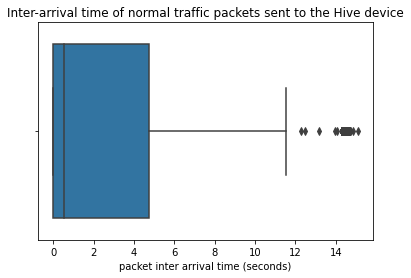

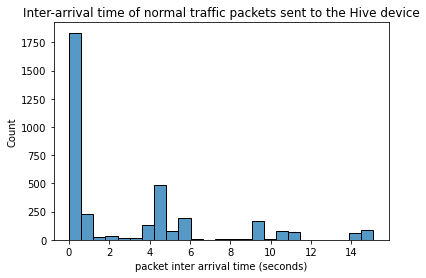

In [ ]:
timer = df.query(f'Destination == "{hive_ipaddr}"')['Time']#[:50]
time_diff = calc_time_diff (timer)

print('average packet interarrivaltime is', np.mean(time_diff))
print('standard deviation of packet interarrivaltime is', np.std(time_diff))
print('range of packet interarrivaltime is', time_diff[1],':',max(time_diff))


p20, p80 = np.percentile(time_diff, [20, 80])
print('80% of the 1mins packet  interarrivaltime is are less  than', 
    round(p80), 'and only 20% of the 1mins packet  interarrivaltime is is ', round(p80) )
# print('20% of the 1mins packet interarrivaltime is less  than', 
#     round(p20), 'and only 80% of the 1mins packet interarrivaltime is ', round(p20) )

sns.boxplot(x=time_diff)
plt.xlabel('packet inter arrival time (seconds)')
plt.title("Inter-arrival time of normal traffic packets sent to the Hive device")
plt.show()

# sns.scatterplot(y=timer.index[:1000],x=random.sample(time_diff,1000))
# # sns.scatterplot(x=timer[:100],y=time_diff[:100])
# plt.xlabel('packet inter arrival time (seconds)')
# plt.title("Inter-arrival time of normal traffic packets sent to the Hive device")
# plt.show()

sns.histplot(time_diff)
plt.xlabel('packet inter arrival time (seconds)')
plt.title("Inter-arrival time of normal traffic packets sent to the Hive device")
plt.show()

## Analyse subsets of the data (first 1 hour traffic flow)

In [ ]:
#### preprocessing and generate additional attributes 
df_firsthour = df_firsthour.replace(np.nan, '')   # to avoid the complexity presented by 'NaN'
df_firsthour.head()

,No.,Time,Source,Destination,Protocol,Length,Time since previous frame in this TCP stream,Time delta from previous captured frame,Sequence Number,TCP Flags,This is an ACK to the segment in frame,TCP payload,Payload,Header Length,Info
0,5,2022-08-26 09:38:36.520313,192.168.0.101,52.210.184.200,TCP,66,0.0,1.191316,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,,,,32.0,58088 > 443 [ACK] Seq=1 Ack=1 Win=8022 Len=0...
1,6,2022-08-26 09:38:36.539808,52.210.184.200,192.168.0.101,TCP,66,0.019495,0.019495,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,,,,32.0,[TCP ACKed unseen segment] 443 > 58088 [ACK]...
2,7,2022-08-26 09:38:37.020608,192.168.0.101,34.240.107.124,TLSv1.2,97,0.0,0.480800,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,,170303001a00000000000005b6f2a077839265cf66d18b...,,32.0,Application Data
3,8,2022-08-26 09:38:37.042073,34.240.107.124,192.168.0.101,TLSv1.2,97,0.021465,0.021465,1.0,\302\267\302\267\302\267\302\267\302\267\302\2...,7.0,170303001a00000000000005b7261c56c3a2b256f85e57...,,32.0,Application Data
4,9,2022-08-26 09:38:37.042570,192.168.0.101,34.240.107.124,TCP,66,0.000497,0.000497,32.0,\302\267\302\267\302\267\302\267\302\267\302\2...,8.0,,,32.0,49730 > 443 [ACK] Seq=32 Ack=32 Win=1002 Len...


#### Variations

##### Packet length variation

Text(0.5, 1.0, 'Packet Length Variation (60 min traffic)')

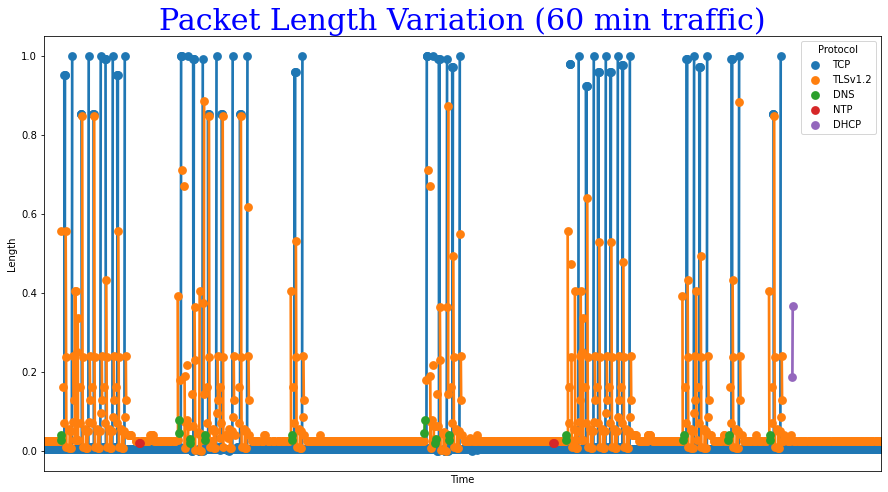

In [ ]:
### MinMax Scaling
df_firsthour['Length'] = MinMaxScaler().fit_transform(df_firsthour.loc[:,['Length']])

plt.figure(figsize = (15,8))
sns.pointplot(x='Time', y='Length',
              hue='Protocol', 
              data=df_firsthour
              )
plt.xticks([])
plt.title(f"Packet Length Variation ({duration_in_minute} min traffic)", fontdict = font1)

In [ ]:
for p in set(df_firsthour['Protocol']):
    dt = df_firsthour.query(f'Protocol == "{p}"')
    print(len(dt))

1631
4
24
2
775


C:\Users\OMApe\AppData\Local\Temp\ipykernel_8340\2192935048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firsthour['Length'] = MinMaxScaler().fit_transform(df_firsthour.loc[:,['Length']])


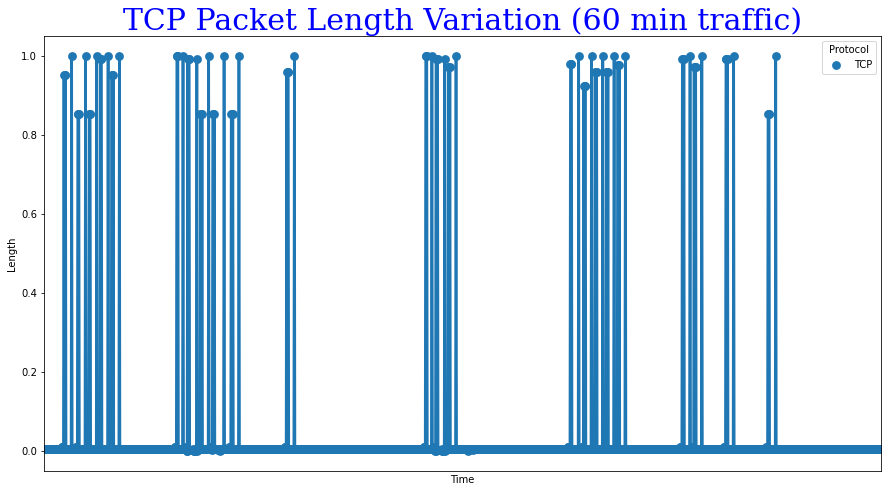

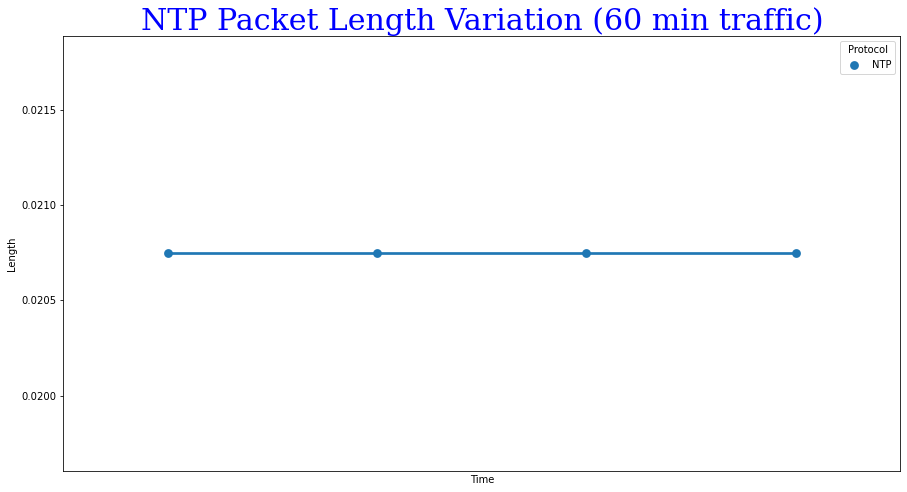

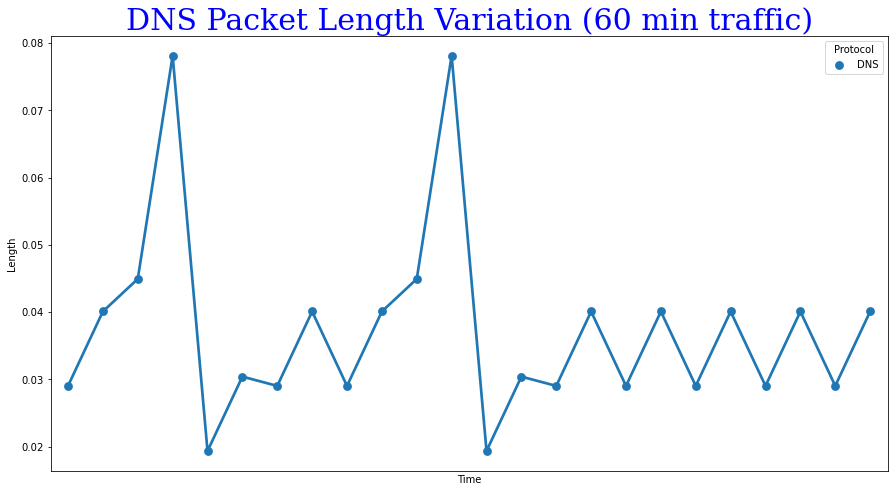

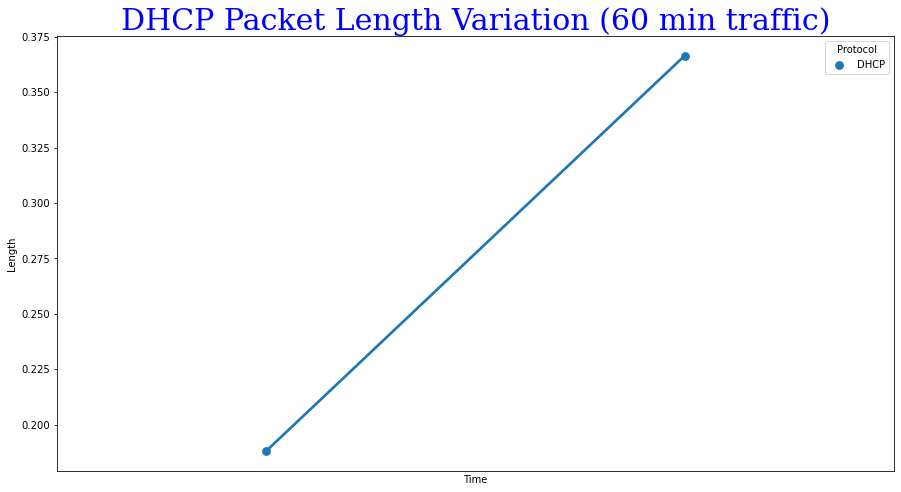

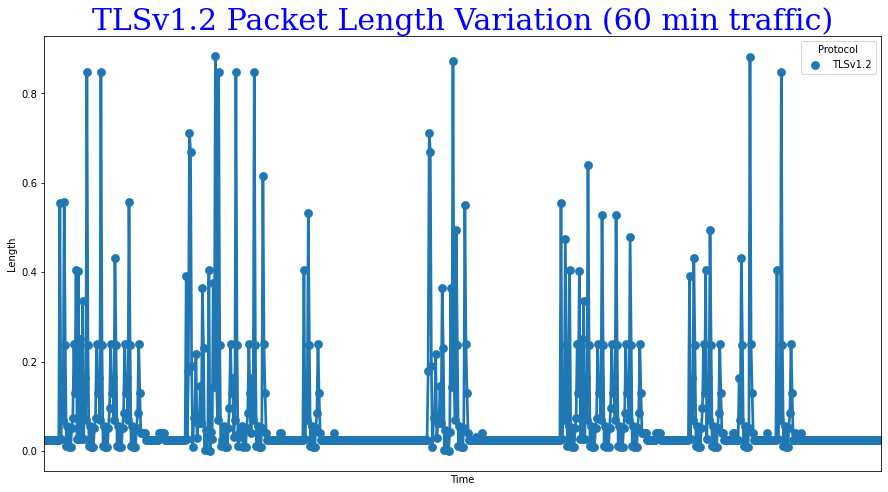

In [ ]:
### MinMax Scaling
df_firsthour['Length'] = MinMaxScaler().fit_transform(df_firsthour.loc[:,['Length']])

for p in set(df_firsthour['Protocol']):
    dt = df_firsthour.query(f'Protocol == "{p}"')
    plt.figure(figsize = (15,8))
    sns.pointplot(x='Time', y='Length',
                hue='Protocol', 
                data=dt
                )
    plt.xticks([])
    plt.title(f"{p} Packet Length Variation ({duration_in_minute} min traffic)", fontdict = font1)
    plt.show()

##### protocol variation

<Figure size 1080x720 with 0 Axes>

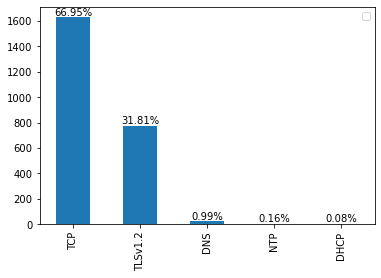

In [ ]:
plt.figure(figsize=(15,10))
ax = pd.DataFrame(df_firsthour['Protocol'].value_counts()).plot(kind='bar')
plt.legend([])
for p in ax.patches:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+15,
      s="{:.2f}%".format(height/len(df_firsthour)*100),
      ha='center')

Normal data encoding: {'DHCP': 0, 'DNS': 1, 'NTP': 2, 'TCP': 3, 'TLSv1.2': 4}


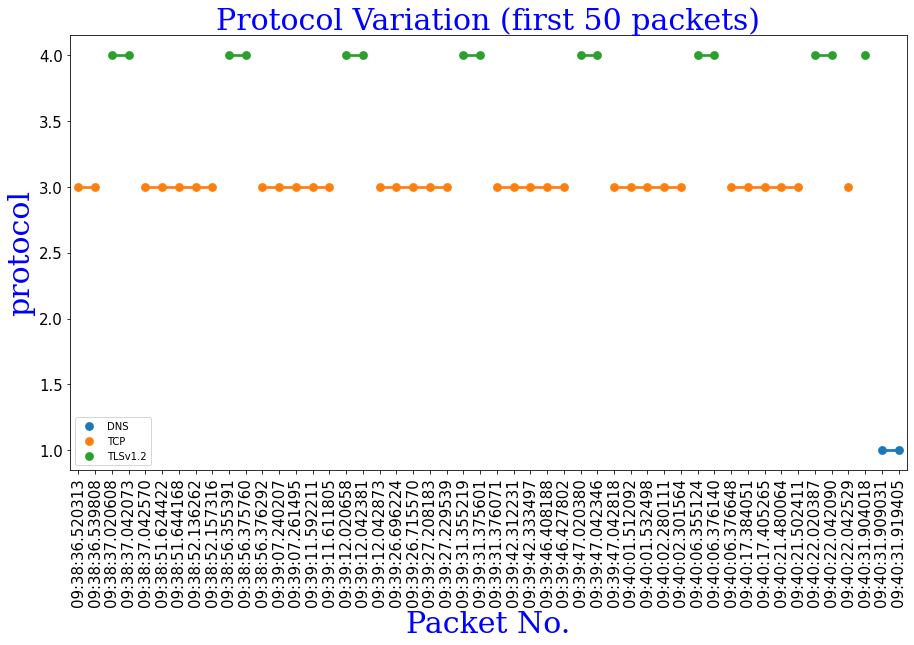

In [ ]:
# preprocess
df_firsthour = time_filter(df, 'Time', duration_in_minute)

normal_protocols = {q:p for p,q in enumerate(sorted(set(df_firsthour.Protocol)))}
print('Normal data encoding:', normal_protocols)
new_df_firsthour = df_firsthour.copy() # create a new data because of the label encoding
new_df_firsthour.Protocol = LabelEncoder().fit_transform(new_df_firsthour.Protocol) 
new_df_firsthour = new_df_firsthour[:50]

# tcpsyn tcpsyn (first 50 packets)
plt.figure(figsize = (15,8))
g = sns.pointplot(x=[t.time() for t in new_df_firsthour.Time], y='Protocol',
              hue='Protocol', 
              data=new_df_firsthour
              )
plt.xticks(rotation=90, fontsize=15)
# plt.xticks([])
plt.yticks(fontsize=15)
plt.ylabel('protocol', fontdict = font1)
plt.xlabel('Packet No.', fontdict = font1)
plt.title("Protocol Variation (first 50 packets)", fontdict = font1)
# rename the legend
current_handles, current_labels = plt.gca().get_legend_handles_labels()
new_labels = [sorted(set(df_firsthour.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

##### Sequence number variation

C:\Users\OMApe\AppData\Local\Temp\ipykernel_8340\4150163462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firsthour['Sequence Number'] = df_firsthour.loc[:,['Sequence Number']].replace({'':-1})
C:\Users\OMApe\AppData\Local\Temp\ipykernel_8340\4150163462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firsthour['Sequence Number'] = MinMaxScaler().fit_transform(df_firsthour.loc[:,['Sequence Number']])


Text(0.5, 1.0, 'Sequence Number Variation (first 50 packets)')

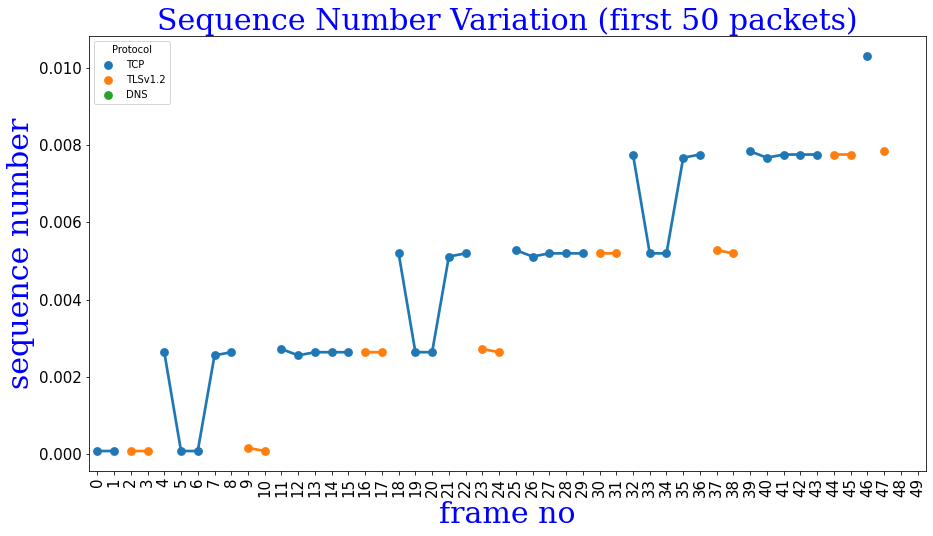

In [ ]:
# Sequence number variation
df_firsthour['Sequence Number'] = df_firsthour.loc[:,['Sequence Number']].replace({'':-1})
df_firsthour['Sequence Number'] = MinMaxScaler().fit_transform(df_firsthour.loc[:,['Sequence Number']])
new_df_firsthour = df_firsthour[:50]

# Visualization
plt.figure(figsize = (15,8))
sns.pointplot(x=new_df_firsthour.index, y='Sequence Number',
             hue='Protocol', 
              data=new_df_firsthour,
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('sequence number', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
# plt.legend(['tcp private'], prop={"size":20})
plt.title("Sequence Number Variation (first 50 packets)", fontdict = font1)

##### Proportion of TCP flags

{'', 'AF', 'S', 'AS', 'R', 'AP', 'APF', 'A', 'AR'}
{'ACKPSH', 'SYN', 'None', 'Others', 'ACKRST', 'ACK', 'ACKSYN', 'ACKFIN'}


Text(0.5, 1.0, 'Proportion of various TCP flags during 1 hour normal traffic flow')

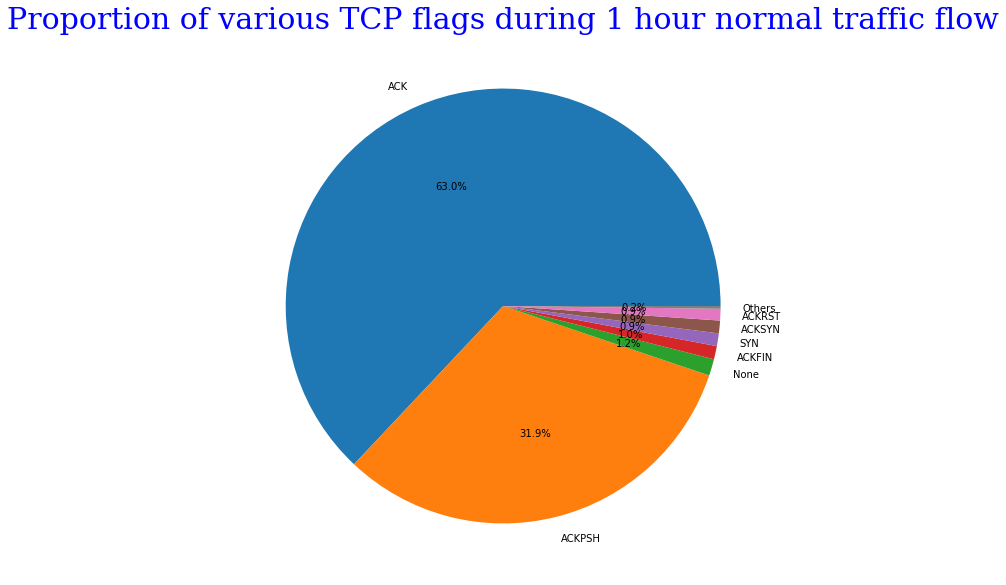

In [ ]:
df_firsthour = df_firsthour.replace(np.nan, '')   # to avoid the complexity presented by 'NaN'
df_firsthour['TCP Flags'] = list(map(get_tcp_flag, df_firsthour['TCP Flags']))
print(set(df_firsthour['TCP Flags']))
df_firsthour['TCP Flags'] = df_firsthour['TCP Flags'].replace({'':'None', 
        'S':'SYN', 'A':'ACK', 'R':'RST','AF':'ACKFIN', 'AR':'ACKRST', 
        'AS':'ACKSYN',  'APF':'ACKPSHFIN', 'AP':'ACKPSH'})
# # group minor flags as others
df_firsthour.loc[df_firsthour.query('`TCP Flags` == "ACKPSHFIN" | `TCP Flags` == "RST"').index,"TCP Flags"] = 'Others' 
print(set(df_firsthour['TCP Flags']))

flag_count = df_firsthour['TCP Flags'].value_counts()
plt.figure(figsize=(10,10))
plt.pie(flag_count, 
        # explode=explode, 
        labels=flag_count.index,
        autopct='%1.1f%%',
        # startangle=90, # to rotate the chart
        )
plt.title("Proportion of various TCP flags during 1 hour normal traffic flow", fontdict = font1)
 

#### IP address Analysis (Prominent traffic sender and reciever)

In [ ]:
# #  prominet IP address source of packet to device 
# pd.DataFrame(df_firsthour.query(f'Destination == "{hive_ipaddr}"').Source.value_counts())#[:10]

# #  prominet IP address Destination of packet from device 
# pd.DataFrame(df_firsthour.query(f'Source == "{hive_ipaddr}"').Destination.value_counts())#[:10]

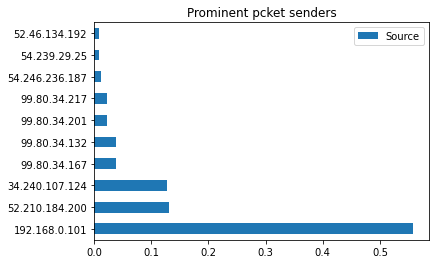

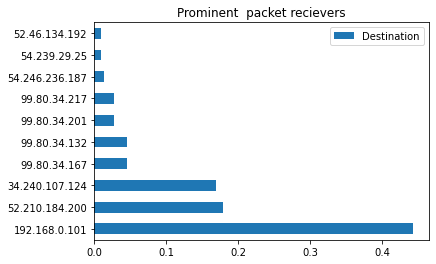

In [ ]:
# from locale import normalize

# normal 
# print(df_firsthour.Source.value_counts()[:10])
# print(df_firsthour.Destination.value_counts()[:10])

# normalised version 
pd.DataFrame(
    df_firsthour.Source.value_counts(normalize=True)[:10]
).plot(
    kind = 'barh',
    title = 'Prominent pcket senders'
    )
plt.show()

pd.DataFrame(
    df_firsthour.Destination.value_counts(normalize=True)[:10]
).plot(
    kind='barh',
    title='Prominent  packet recievers'
    )
plt.show()

# set(df_firsthour.Source)

#### Inflow/Outflow traffic analysis

Total inflow traffic for 60 mins window is 1078
Total inflow traffic for 60 mins window is 1358


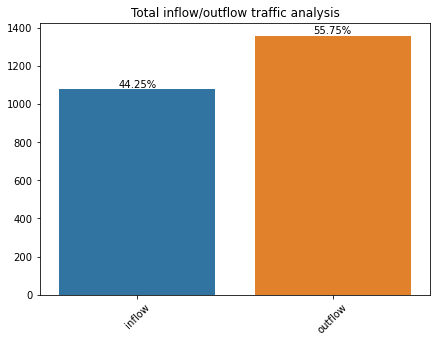

In [ ]:
# Total infow Traffic
inflow_traffic = df_firsthour.query("Destination == '192.168.0.101'")
print(f'Total inflow traffic for {duration_in_minute} mins window is',\
    len(inflow_traffic))

# Total outflow traffic
outflow_traffic = df_firsthour.query("Source == '192.168.0.101'")
print(f'Total inflow traffic for {duration_in_minute} mins window is',\
    len(outflow_traffic))

plt.figure(figsize=(7,5))
ax = sns.barplot(y=[len(inflow_traffic), len(outflow_traffic)], x=['inflow', 'outflow'])
plt.xticks(rotation=45, fontsize=10)
plt.title('Total inflow/outflow traffic analysis')
# to add text to the chart 
for p in ax.patches:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+10,
      s="{:.2f}%".format(height/len(df_firsthour)*100),
      ha='center')
plt.show()

#### The two-way flow analysis
pointing down  = inflow
pointing up = outflow

Text(0.5, 1.0, 'The two-way flow analysis of normal Hive traffic (5 mins flow))')

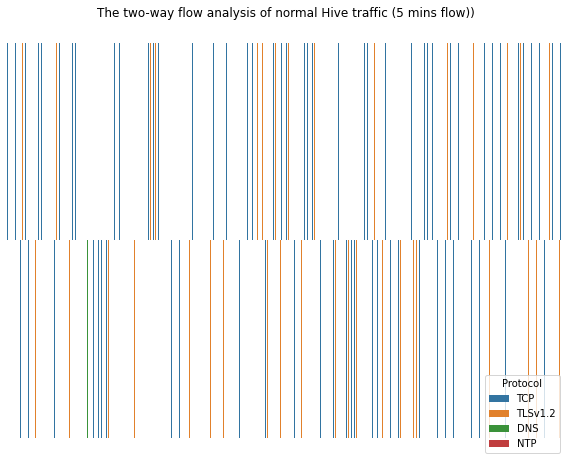

In [ ]:
mins = 5
tcp_df = time_filter(df.replace(np.nan, '') , 'Time', mins)
# tcp_df['TCP Flags'] = list(map(get_tcp_flag, tcp_df['TCP Flags']))
flow_dir = [1 if s == hive_ipaddr else -1 for s in tcp_df.Source]
plt.figure(figsize = (10,8))
g = sns.barplot(x=tcp_df.index, y=flow_dir, hue=tcp_df.Protocol)
plt.axis('off')
plt.title(f"The two-way flow analysis of normal Hive traffic ({mins} mins flow))")

# n = len(df_firsthour)
# # n = 100
# flow_dir = [1 if s == hive_ipaddr else -1 for s in df_firsthour.Source]
# plt.figure(figsize = (15,8))
# g = sns.barplot(x=df_firsthour[:n].index, y=flow_dir[:n], 
#                 hue=df_firsthour[:n].Protocol)
# # handles, labels  =  g.get_legend_handles_labels()
# # g.legend(handles, ['inflow', 'outflow'], loc='lower right')
# plt.axis('off')
# plt.title("The two-way flow analysis of normal Hive traffic (1 hour flow))")

Text(0.5, 1.0, 'The two-way flow analysis of normal Hive TCP flags traffic (2 min flow))')

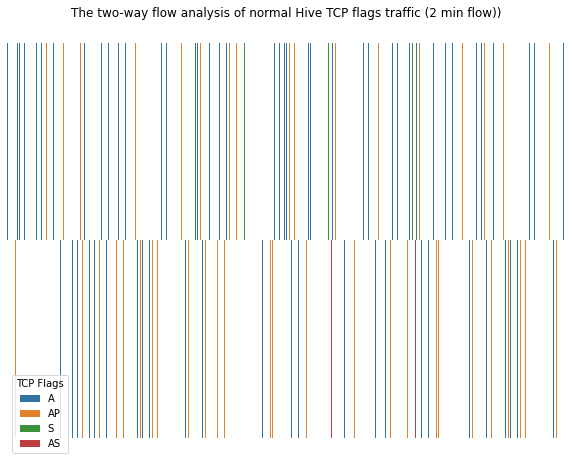

In [ ]:
# mins = 2
# tcp_df = time_filter(df.replace(np.nan, '') , 'Time', mins)
# tcp_df['TCP Flags'] = list(map(get_tcp_flag, tcp_df['TCP Flags']))
# tcp_df = tcp_df.query('`TCP Flags` != ""').reset_index(drop=True)
# flow_dir = [1 if s == hive_ipaddr else -1 for s in tcp_df.Source]
# plt.figure(figsize = (10,8))
# g = sns.barplot(x=tcp_df.index, y=flow_dir, hue=tcp_df['TCP Flags'])
# plt.axis('off')
# plt.title(f"The two-way flow analysis of normal Hive TCP flags traffic ({mins} min flow))")

#### flow of TCP keep alive packets
How soon is the TCP keep alive sent?

need more work

[0.0, 0.02, 15.08, 0.02, 4.33, 0.02, 15.08, 0.02, 0.49, 0.02, 15.08, 0.02, 4.07, 0.02, 15.08, 0.02, 0.75, 0.02, 15.08, 0.02, 4.07, 0.02, 15.59, 0.02, 12.27, 0.02, 2.8, 0.02, 12.27, 0.02, 7.66, 0.02, 9.19, 0.02, 5.87, 0.02, 9.19, 0.02, 10.73, 0.02, 9.19, 0.02, 5.87, 0.02, 9.19, 0.02, 10.48, 0.02, 9.45, 0.02]


Text(0.5, 1.0, 'Frequency of TCP Keep alive packets (first 50 packets)')

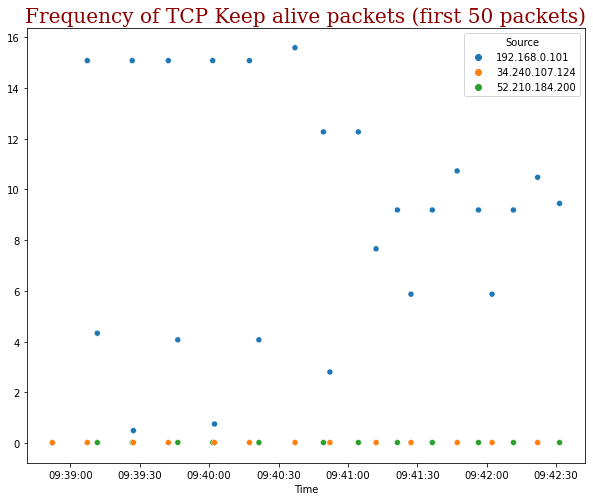

In [ ]:
# df_firsthour['is_ka'] = list(map(is_keep_alive,df_firsthour.Info))  # check if packet is a keep alive 
# is_ka_df = df_firsthour.query(f'is_ka == True').reset_index()
# is_ka_df.is_ka = 1
# is_ka_timer = is_ka_df['Time'][:50]
# time_diff_ka = calc_time_diff(is_ka_timer)
# print(time_diff_ka)

# plt.figure(figsize = (10,8))
# sns.scatterplot(x=is_ka_df.Time[:50], y=time_diff_ka,  
#                 # hue=time_diff_ka
#                 hue=is_ka_df['Source'][:50]
#                 )
# plt.title("Frequency of TCP Keep alive packets (first 50 packets)", fontdict = font2)

#### DNS packets and NTP packets inter-arrival time

C:\Users\OMApe\AppData\Local\Temp\ipykernel_8340\1694237230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dns_df.Protocol = 1


[0.0, 0.01, 2.79, 0.01, 1.05, 0.01, 1.06, 0.01, 1.02, 0.01, 17.66, 0.01, 0.54, 0.01, 0.75, 0.01, 57.35, 0.01, 2.29, 0.01, 59.07, 0.01, 4.3, 0.01]


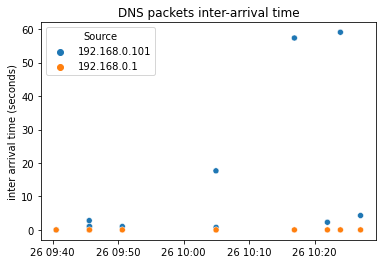

In [ ]:
# dns_df = df_firsthour.query(f'Protocol == "DNS"')
# dns_df.Protocol = 1
# dns_time_df = calc_time_diff(dns_df.Time)
# print(dns_time_df)

# sns.scatterplot(x=dns_df.Time, y=dns_time_df, hue=dns_df.Source)
# plt.title('DNS packets inter-arrival time')
# # plt.xticks([])
# plt.xlabel('')
# plt.ylabel('inter arrival time (seconds)')
# plt.show()

[0.0, 0.02, 8.23, 0.02, 8.23, 0.02, 8.23, 0.02, 8.23, 0.02, 8.23, 0.02]


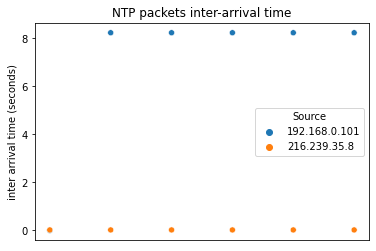

In [ ]:
# ntp_df = df.query(f'Protocol == "NTP" and Source == "{hive_ipaddr}"')
ntp_df = df.query(f'Protocol == "NTP"')
# ntp_df.Protocol = 1
ntp_time_df = calc_time_diff(ntp_df.Time)
print(ntp_time_df)
sns.scatterplot(x=ntp_df.Time, y=ntp_time_df, hue=ntp_df.Source)
plt.title('NTP packets inter-arrival time')
plt.xticks([])
plt.xlabel('')
plt.ylabel('inter arrival time (seconds)')
plt.show()


# Proposed Attack Detection Method
1.1.1	Feature extraction for Machine learning model

1.1.2	Training of an Anomaly Detection model

1.1.3	Testing of the anomaly detection model

1.1.4	Continuous monitoring

### functions

In [144]:
# PREPROCESSING
def get_tcp_flag(n):
  return ''.join(re.findall("[a-zA-Z]", n)) 

def difference_fist_last(x):
    return x.iloc[-1] - x.iloc[0]

def scale_data (data, scaler):       
    scaled_X = scaler.transform(data) 
    return pd.DataFrame(scaled_X, columns=data.columns)

def strip_seconds (time):
    'return the seconds and microseconds part of a timedelta object as a float (sec.microseconds)'
    return round(float(str(time).split()[2].split(':')[2]),5)

# MAKE FLOW DATA
def extract_flow_metrics(rolling_df, flow_dt): 
    'for extracting flow metric from traffic data as a dictionary' 
    # transform the data
    rolling_df = rolling_df.replace(np.nan, '')   # to avoid the error presented by 'NaN'
    
    # TCP Flag variation
    TCP_flags = list(map(get_tcp_flag, rolling_df['TCP Flags']))      
    flow_dt['no_tcp_flags'].append(len(set(TCP_flags)))
    flow_dt['has_syn_flag'].append(''.join(TCP_flags).count('S'))
    flow_dt['has_ack_flag'].append(''.join(TCP_flags).count('A'))
    flow_dt['has_fin_flag'].append(''.join(TCP_flags).count('F'))
    flow_dt['has_rst_flag'].append(''.join(TCP_flags).count('R'))
    flow_dt['has_psh_flag'].append(''.join(TCP_flags).count('P'))

    # packet interarrival time and flow duration
    flow_dt['average_pack_time'].append(np.mean(calc_time_diff(rolling_df.Time)))
    flow_dt['flow_dur'].append(difference_fist_last(rolling_df.Time).seconds) # to be used if rolling by index

    # flow volume
    # flow_dt['flow_volume'].append(len(rolling_df)) # to be used if rolling by time

    # protocol variation
    flow_dt['count_icmp'].append(rolling_df.Protocol.tolist().count('ICMP'))
    flow_dt['count_udp'].append(rolling_df.Protocol.tolist().count('UDP'))
    flow_dt['count_tcp'].append(rolling_df.Protocol.tolist().count('TCP'))  
    flow_dt['count_tlsv'].append(rolling_df.Protocol.tolist().count('TLSv1.2'))  
    flow_dt['count_ntp'].append(rolling_df.Protocol.tolist().count('NTP'))  
    flow_dt['count_dns'].append(rolling_df.Protocol.tolist().count('DNS'))  
    flow_dt['no_unique_prot'].append(len(rolling_df.Protocol.unique()))

    # proportion of inflow to outflow

    # TCP packet lenght variation
    flow_dt['av_pl'].append(rolling_df.Length.mean())         
    flow_dt['tcp_pl'].append(len(set(rolling_df.query("Protocol=='TCP'").Length)))      

    # sequence no variation
    try: 
        flow_dt['av_sn'].append(np.mean([float(item) for item in rolling_df["Sequence number"]]))
    except:
        flow_dt['av_sn'].append(-1)   
    return flow_dt 
    
def make_flow_data(df, roller=47, step=2):
    'convert a flow data dictionary into  dataframe'  
    flow_dt = {'flow_dur':[],'pkt_start':[], 'pkt_end':[], 'no_tcp_flags':[], 
                'has_syn_flag':[], 'has_ack_flag':[], 'has_fin_flag':[], 'has_rst_flag':[], 
                'has_psh_flag':[], 'count_icmp':[], 'count_udp':[], 'count_tcp':[],
                'count_tlsv':[], 'count_ntp':[], 'count_dns':[], 'no_unique_prot':[],       
                'average_pack_time':[], 'av_pl':[], 'tcp_pl':[], 'av_sn':[]
            }
    
    # def feature_row_counter (df, time_colname = 'Time', sec_step = 5):
    # total_duration = df[time_colname].to_list()[-1]-df.Time.to_list()[0]
    # row_counter = []
    # dur = 0
    # start = df.Time.to_list()[0] + dt.timedelta(seconds=dur)
    # while start <= total_duration:
    #     end = start + dt.timedelta(seconds=sec_step)   
    #     r = df.query(f"{time_colname} >= '{start}' & {time_colname} < '{end}'")

    flow_id = 1
    start = 0
    roller = roller
    step = step
    print('Sliding Window is ', 1+roller+step)

    for r in range(0, len(df), step):                               
        if (r+roller > len(df)): 
    #         print (start, ':', len(df))
            flow_dt['pkt_start'].append(start)
            flow_dt['pkt_end'].append(len(df))
            rolling_df = df[start:end]
        else :
            if r == 0:
                continue 
            else:
                end = r+roller
    #             print(start, ':', r+roller)
                rolling_df = df[start:end]
                flow_dt['pkt_start'].append(start)
                flow_dt['pkt_end'].append(end)
                
        flow_dict = extract_flow_metrics(rolling_df, flow_dt)
        start = r
        flow_id+= 1
    return pd.DataFrame.from_dict(flow_dict).iloc[:,0:]        

# MODEL EVALUATION
def print_model_eval (y_true, y_pred):    
    accuracy = accuracy_score
    b_accuracy = balanced_accuracy_score
    print('='*50)
    print('Accuracy: ', accuracy(y_true, y_pred))  
    print('Balance Accuracy: ', b_accuracy(y_true, y_pred))
    print('='*50)

# VISUALIZATION
def get_pca (df, scale=True): 
    pca = sklearn.decomposition.PCA(n_components=2)
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)]) if scale else Pipeline([('pca', pca)])
    pca_df = pipe.fit_transform(df)
    print('PCA explained variance ratio:', pca.explained_variance_ratio_)
    return pca_df
                     
# Predicted label visualisation
def plot_pred_label (pca_data, y_pred, title):
    plot = sns.scatterplot(x = pca_data[:,0], y = pca_data[:,1], 
                    hue=y_pred, alpha=None, palette= "tab10"
                   )
    plot.set(title = f"Predicted label visualisation ({title})")
    plt.show() 

# True label visualisation
def plot_true_label (pca_data, y_true, title):
    plot = sns.scatterplot(x = pca_data[:,0], y = pca_data[:,1], 
                    hue=y_true, alpha=None, palette= "tab10"
                   )
    plot.set(title = f"True label visualisation ({title})")
    plt.show()

def make_novelty_model (flow_data, model=None, scaler=None, scale=True, plot_eval=True, 
                        test_size=0.2, train_model=True):
    'If train_model is set to `False`, you must supply already fitted `model` and `scaler`\
    '
    # cv_model = model ###########################

    #2 Preprocess data
    y = flow_data['label']
    X = flow_data.drop(columns = ['pkt_start','pkt_end', 'label'])  # drop dummy columns  
    X['av_sn'].replace([np.nan], -1, inplace=True)   # encode flows with no average sequece number (nan) with -1

    #3 create scaler and scale the data
    if train_model: scaler = StandardScaler().fit(X)  
    if scale: 
        X = scale_data(X, scaler)

    
    #4 split out test set (use all is already trained model is supplied i.e train_model=False)
    if train_model:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10, shuffle=True)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.99, random_state=10, shuffle=True)

    #4 modeling and validation using 5 fold cross validation
    if  model==None: 
        model = IsolationForest(max_samples='auto', contamination=0.001, 
                                random_state=1, n_estimators=100)
    modelname=type(model).__name__   # get the name of the model for printing purpose
    y_train = y_train.replace({'normal':1})
    cv_results = sklearn.model_selection.cross_validate(model, X_train, y_train, cv=5, scoring='accuracy')

    #5 final model evaluate using test data
    if train_model: 
            model.fit(X_train)
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred).replace({1:'normal', -1:'novel'})

    #6 visualization
    if plot_eval:
        pca_test = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
        plot_pred_label (pca_test, y_pred, title = f'{modelname} Test data') # predicted label
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        plt.show()

    index = np.where(y_pred=='novel')[0]
    # print(modelname, '===>', 'no of test set -', len(X_test), ':', 'no of novel data -', len(X_test.iloc[index]))
    # print(modelname, '===>', 'no of test set -', len(X_test), ':', 'Accuracy -', f'{round((1-len(X_test.iloc[index])/len(X_test))*100,2)}%')
    print(f"{modelname} 5 fold accuracies are {[round(c*100, 2) for c in cv_results['test_score']]}.")
    print(f"{modelname} average cross validation accuracy is {round(np.mean(cv_results['test_score'])*100,2)}%.")
    print(f'The {modelname} model misclassified {len(X_test.iloc[index])} instances as novel out of the {len(X_test)} instances of the test data')
    print(f"The model's accuracy score on test data is {round((1-len(X_test.iloc[index])/len(X_test))*100,2)}%")

    if train_model: return model, scaler

### Feature extraction for Machine learning model
label encoding: 
scaling: the following variables, , were scaled to prevent large values dominating the smaller values. 

In [103]:
flow_dt = make_flow_data(df, roller=47, step=2)
flow_dt['label'] = 'normal'
flow_dt.head(10)

,flow_dur,pkt_start,pkt_end,no_tcp_flags,has_syn_flag,has_ack_flag,has_fin_flag,has_rst_flag,has_psh_flag,count_icmp,...,count_tcp,count_tlsv,count_ntp,count_dns,no_unique_prot,average_pack_time,av_pl,tcp_pl,av_sn,label
0,115,0,49,3,0,48,0,0,15,0,...,33,15,0,1,3,2.354286,91.857143,1,-1,normal
1,114,2,51,3,0,47,0,0,16,0,...,31,16,0,2,3,2.345102,93.591837,1,-1,normal
2,114,4,53,4,1,46,0,0,14,0,...,33,14,0,2,3,2.344694,92.489796,2,-1,normal
3,100,6,55,5,2,46,0,0,14,0,...,33,14,0,2,3,2.047143,92.653061,2,-1,normal
4,99,8,57,5,2,46,0,0,15,0,...,32,15,0,2,3,2.039388,97.346939,2,-1,normal
5,95,10,59,5,2,46,0,0,15,0,...,32,15,0,2,3,1.953265,126.591837,3,-1,normal
6,84,12,61,5,2,46,0,0,14,0,...,33,14,0,2,3,1.731633,153.877551,3,-1,normal
7,80,14,63,5,2,46,0,0,15,0,...,32,15,0,2,3,1.642857,198.102041,3,-1,normal
8,80,16,65,5,2,46,0,0,17,0,...,30,17,0,2,3,1.634082,205.183673,3,-1,normal
9,80,18,67,5,2,46,0,0,15,0,...,32,15,0,2,3,1.633673,203.918367,3,-1,normal


In [ ]:
flow_dt.shape

(3976, 21)

### Training and evaluation of Anomaly Detection models

PCA explained variance ratio: [0.42708386 0.16454025]


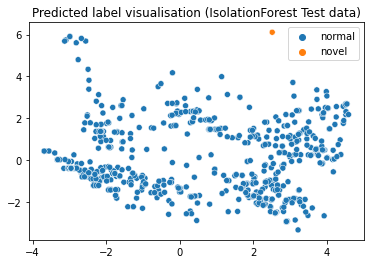

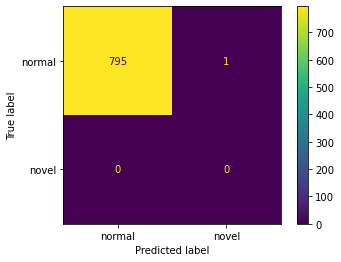

IsolationForest 5 fold accuracies are [99.84, 99.84, 99.53, 99.69, 100.0].
IsolationForest average cross validation accuracy is 99.78%.
The IsolationForest model misclassified 1 instances as novel out of the 796 instances of the test data
The model's accuracy score on test data is 99.87%
PCA explained variance ratio: [0.42708386 0.16454025]


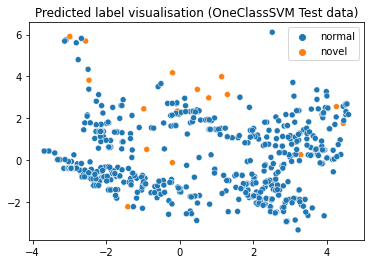

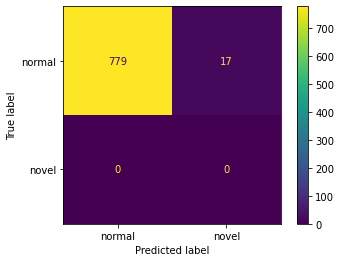

OneClassSVM 5 fold accuracies are [97.96, 97.33, 97.01, 96.86, 97.01].
OneClassSVM average cross validation accuracy is 97.23%.
The OneClassSVM model misclassified 17 instances as novel out of the 796 instances of the test data
The model's accuracy score on test data is 97.86%
PCA explained variance ratio: [0.42708386 0.16454025]


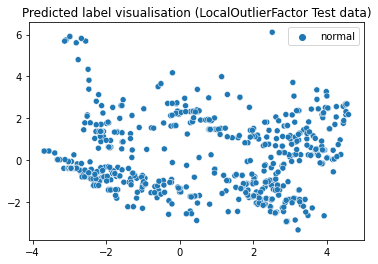

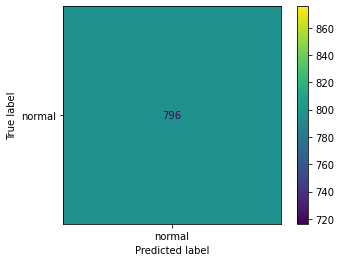

LocalOutlierFactor 5 fold accuracies are [99.84, 99.69, 100.0, 100.0, 99.84].
LocalOutlierFactor average cross validation accuracy is 99.87%.
The LocalOutlierFactor model misclassified 0 instances as novel out of the 796 instances of the test data
The model's accuracy score on test data is 100.0%


In [152]:
# IsolationForest
make_novelty_model (flow_dt)

# OneClassSVM model 
model = OneClassSVM(kernel='rbf', degree=3, gamma='scale', nu=0.005)
make_novelty_model (flow_dt, model=model, scale=True)

# LoF model
model = LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                         metric='minkowski', contamination=0.001,
                         novelty=True, n_jobs=-1)
trained_model, trained_scaler = make_novelty_model (flow_dt, model=model, scale=True)

# save model and scaler 
pickle.dump(trained_scaler, open('models/novelty_scaler', 'wb'))  
pickle.dump(trained_model, open('models/novelty_model', 'wb')) 

### final model for the Network Intrusion Detection System (IDS)

In [154]:
trained_model

LocalOutlierFactor(contamination=0.001, n_jobs=-1, novelty=True)

c:\Users\OMApe\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


PCA explained variance ratio: [0.42061669 0.15575485]


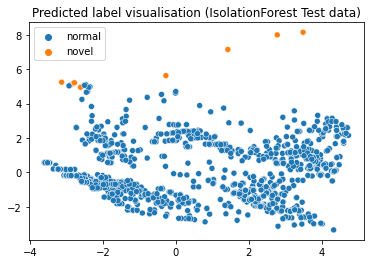

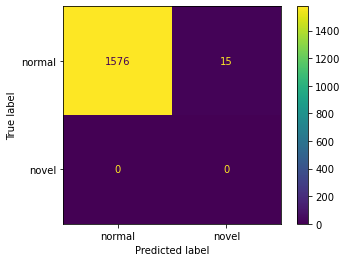

The IsolationForest model misclassified 15 instances as novel out of the 1591 instances of the test data
The model has 99.06% accuracy


(IsolationForest(contamination=0.01, random_state=1), StandardScaler())

In [40]:
# using the model to predict on 99 of the original data. 
# make_novelty_model (flow_dt, model=model, scaler=scaler,
#                 scale=True, plot_eval=True, train_model=False)

# prediction on test set. 
# (will produce same result as in the training section just that we print visuals here by setting plot_eval to the default value - True)
make_novelty_model (flow_dt, test_size=0.4)

### Continuous monitoring

In [41]:
# # predict on all atack flow
# attack_labels = ['ICMPprivate', 'TCPSYNprivate', 'UDPprivate', 'benignprivate']
# for l in attack_labels:
#     # flow_dt = flow_data.query(f"label == '{attack_labels[1]}'")
#     print ('='*20, l, '='*20)
#     flow_dt = flow_data.query(f"label == '{l}'")
#     make_novelty_model (flow_dt, model=model, scaler=scaler, plot_eval=True, train_model=False)

# # trial codes for combined data
# attack_labels = ['ICMPprivate', 'TCPSYNprivate', 'UDPprivate', 'benignprivate']
# flow_dt = flow_data.query(f"label == '{attack_labels[0]}' | label == '{attack_labels[3]}'")
# make_novelty_model (flow_dt, model=model, scaler=scaler, plot_eval=True, train_model=False)